# Проект по А/B-тестированию

**Постановка задачи**

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
 - Оцените корректность проведения теста
 - Проанализируйте результаты теста
 
Чтобы оценить корректность проведения теста, проверьте:
 - пересечение тестовой аудитории с конкурирующим тестом,
 - совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

**Техническое задание**
- Название теста: recommender_system_test;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
 - конверсии в просмотр карточек товаров — событие product_page
 - просмотры корзины — product_card
 - покупки — purchase.

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:
- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:
- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:
- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## Загрузка данных

In [1]:
import pandas as pd
import plotly.express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st

In [2]:
marketing_events=pd.read_csv('/datasets/ab_project_marketing_events.csv')

In [3]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes


In [4]:
new_users=pd.read_csv('/datasets/final_ab_new_users.csv')

In [5]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


In [6]:
events=pd.read_csv('/datasets/final_ab_events.csv')

In [7]:
events.head()

user_id             event_dt event_name  details
0  E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504  2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C  2020-12-07 12:59:29   purchase     4.99
3  96F27A054B191457  2020-12-07 04:02:40   purchase     4.99
4  1FD7660FDF94CA1F  2020-12-07 10:15:09   purchase     4.99

In [8]:
participants=pd.read_csv('/datasets/final_ab_participants.csv')

In [9]:
participants.head()

user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  482F14783456D21B     B  recommender_system_test

Необходимо поменять тип данных во всех столбцах с датами и можно заменить название столбца details на purchase таблицы events.

## Предобработка данных

**Поменяем тип данных у столбцов указывающих дату**

In [10]:
marketing_events['start_dt']=pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt']=pd.to_datetime(marketing_events['finish_dt'])
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null datetime64[ns]
finish_dt    14 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [11]:
new_users['first_date']=pd.to_datetime(new_users['first_date'])
events['event_dt']=pd.to_datetime(events['event_dt'])
events['date']=events['event_dt'].dt.strftime('%Y-%m-%d')

In [12]:
events = events.rename(columns={'details': 'purchase'})

**Поиск пропусков и дубликатов**

In [13]:
marketing_events.isnull().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [14]:
marketing_events.duplicated().sum()

0

In [15]:
new_users.isnull().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [16]:
new_users.duplicated().sum()

0

In [17]:
events.isnull().sum()

user_id            0
event_dt           0
event_name         0
purchase      377577
date               0
dtype: int64

In [18]:
events.duplicated().sum()

0

In [19]:
participants.isnull().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [20]:
participants.duplicated().sum()

0

**Заменим все пропуски в events на 0,** так как покупка не могла стоить 0,значит 0 будет означать неполную информацию

In [21]:
events=events.fillna(0)
events.isnull().sum()

user_id       0
event_dt      0
event_name    0
purchase      0
date          0
dtype: int64

## Исследовательский анализ данных

### Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

**Время проведения теста**

In [22]:
new_users['first_date'].describe()

count                   61733
unique                     17
top       2020-12-21 00:00:00
freq                     6290
first     2020-12-07 00:00:00
last      2020-12-23 00:00:00
Name: first_date, dtype: object

Можно заметить, что по заданию сказано, что набор новых пользователей закончился 21.12, хотя в таблице есть участники зарегистрировавшиеся 23.12, изменим данные по пользовталем, заменив на тех, кто зарегистрировался только до конца регистрации

In [23]:
new_users=new_users.query('first_date<="2020-12-21"')

In [24]:
events['event_dt'].describe()

count                  440317
unique                 267268
top       2020-12-23 02:37:24
freq                       10
first     2020-12-07 00:00:33
last      2020-12-30 23:36:33
Name: event_dt, dtype: object

А в событиях новых пользователей не хватает действий с 31.12 по 04.01, хотя по заданию они должны быть

In [25]:
marketing_events['start_dt'].describe()

count                      14
unique                     14
top       2020-02-14 00:00:00
freq                        1
first     2020-01-25 00:00:00
last      2020-12-30 00:00:00
Name: start_dt, dtype: object

In [26]:
marketing_events['finish_dt'].describe()

count                      14
unique                     14
top       2020-05-11 00:00:00
freq                        1
first     2020-02-07 00:00:00
last      2021-01-07 00:00:00
Name: finish_dt, dtype: object

Проверим попали ли какие-нибудь маркетинговые события в период проведения аб-теста

In [27]:
marketing_events.query('start_dt < "2021-01-04" and finish_dt > "2020-12-07"')

name        regions   start_dt  finish_dt
0    Christmas&New Year Promo  EU, N.America 2020-12-25 2021-01-03
10  CIS New Year Gift Lottery            CIS 2020-12-30 2021-01-07

### В выборках встречаются одни и те же пользователи?

**Аудиторию теста. Удостоверимся, что нет пересечений с конкурирующим тестом. Проверим равномерность распределения по тестовым группам и правильность их формирования**

In [28]:
participants['user_id'].nunique()

16666

In [29]:
participants[participants['ab_test']=='recommender_system_test']['user_id'].nunique()

6701

In [30]:
participants[participants['ab_test']=='interface_eu_test']['user_id'].nunique()

11567

Так как сумма уникальных пользователей двух тестов больше, чем количество уникальных пользователей таблицы => можно сделать вывод, что они точно пересекаются

In [31]:
ab_users=participants[participants['ab_test']=='recommender_system_test']

In [32]:
interface_users=participants[participants['ab_test']=='interface_eu_test']

In [33]:
new_parti=pd.merge(ab_users,interface_users,on='user_id',how='left')

In [34]:
participants = new_parti.query('ab_test_y != "interface_eu_test"')
participants = participants[['user_id', 'group_x', 'ab_test_x']]

Получилось 5099 пользователей, а должно быть 6000 

In [35]:
participants = participants[['user_id', 'group_x']]

In [36]:
df_ext = events.merge(new_users, on = 'user_id', how = 'left')
df = df_ext.merge(participants, on = 'user_id')

In [37]:
df['user_id'].nunique()

2788

Количество пользователей группы А

In [38]:
len(df[df['group_x']=='A']['user_id'].unique())

2082

Количество пользователей группы В

In [39]:
len(df[df['group_x']=='B']['user_id'].unique())

706

Группы пользователей А и В не пересекаются

Проверка для аудитории на 15% из EU

In [93]:
all_region_users=new_users.groupby('region').agg({'user_id': 'count'}).reset_index()
all_region_users=all_region_users.rename(columns={'user_id':'all_users'})
all_region_users

region  all_users
0       APAC       2883
1        CIS       2900
2         EU      42340
3  N.America       8347

In [94]:
region_users = df.drop_duplicates('user_id').groupby('region').agg({'user_id': 'count'}).reset_index()
region_users

region  user_id
0       APAC       45
1        CIS       30
2         EU     2594
3  N.America      119

In [95]:
region_users=pd.merge(region_users, all_region_users, on='region',how='left')
region_users['percent']=region_users['user_id']/region_users['all_users']*100
region_users

region  user_id  all_users   percent
0       APAC       45       2883  1.560874
1        CIS       30       2900  1.034483
2         EU     2594      42340  6.126594
3  N.America      119       8347  1.425662

В итоге получилось, что количество пользователей из Европы всего 6,1%, а по техзаданию должно быть 15%

### Как меняется конверсия в воронке на разных этапах?

Для начала рассмотрим воронку для всех пользователей

In [40]:
event_users = df.groupby('event_name').agg({'user_id':['count','nunique']}).reset_index()
event_users.set_axis(['event_name', 'count', 'nunique'], axis = 'columns',inplace = True)
event_users = event_users.sort_values(by='nunique', ascending=False)

In [41]:
event_users['percent'] = (event_users['nunique'] / len(df['user_id'].unique()) * 100)
event_users = event_users.reset_index(drop=True)
event_users

event_name  count  nunique     percent
0         login   8501     2788  100.000000
1  product_page   5298     1757   63.020086
2      purchase   2483      850   30.487805
3  product_cart   2522      826   29.626973

In [107]:
fig = go.Figure(go.Funnel(
    y = event_users['event_name'],
    x = event_users['nunique'],
    textinfo = 'value + percent initial'))
fig.show();

**Воронка группы А**

In [43]:
df_A=df[df['group_x']=='A']

In [44]:
A_event_users = df_A.groupby('event_name').agg({'user_id':['count','nunique']}).reset_index()
A_event_users.set_axis(['event_name', 'count', 'nunique'], axis = 'columns',inplace = True)
A_event_users = A_event_users.sort_values(by='nunique', ascending=False)

In [45]:
A_event_users['percent'] = (A_event_users['nunique'] / len(df_A['user_id'].unique()) * 100)
A_event_users = A_event_users.reset_index(drop=True)
A_event_users

event_name  count  nunique     percent
0         login   6525     2082  100.000000
1  product_page   4250     1360   65.321806
2      purchase   1973      652   31.316042
3  product_cart   1989      631   30.307397

In [105]:
fig = go.Figure(go.Funnel(
    y = A_event_users['event_name'],
    x = A_event_users['nunique'],
    textinfo = 'value + percent initial'))
fig.show();

**Воронка группы B**

In [47]:
df_B=df[df['group_x']=='B']

In [48]:
B_event_users = df_B.groupby('event_name').agg({'user_id':['count','nunique']}).reset_index()
B_event_users.set_axis(['event_name', 'count', 'nunique'], axis = 'columns',inplace = True)
B_event_users = B_event_users.sort_values(by='nunique', ascending=False)

In [49]:
B_event_users['percent'] = (B_event_users['nunique'] / len(df_B['user_id'].unique()) * 100)
B_event_users = B_event_users.reset_index(drop=True)
B_event_users

event_name  count  nunique     percent
0         login   1976      706  100.000000
1  product_page   1048      397   56.232295
2      purchase    510      198   28.045326
3  product_cart    533      195   27.620397

In [106]:
fig = go.Figure(go.Funnel(
    y = B_event_users['event_name'],
    x = B_event_users['nunique'],
    textinfo = 'value + percent initial'
    ))
fig.show();

В воронке группы В должно быть улучшение на 10% по сравнению с группой А, но улучшения нет.

### Количество событий на пользователя одинаково распределены в выборках?

В группе А

In [51]:
df_A['event_name'].count()/df_A['user_id'].nunique()

7.0782901056676275

В группе В

In [52]:
df_B['event_name'].count()/df_B['user_id'].nunique()

5.760623229461756

### Как число событий распределено по дням?

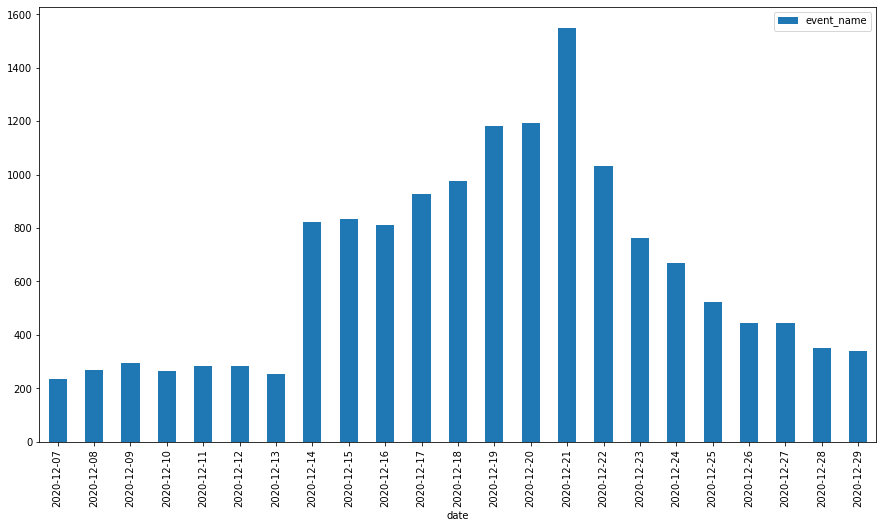

In [53]:
df_A.groupby('date').agg({'event_name': 'count'}).plot(kind='bar', figsize=(15, 8))
plt.show()

Для группы А: первая неделя затишье, затем резкий прирост количества событий 21.12 пик и затем на снижение.

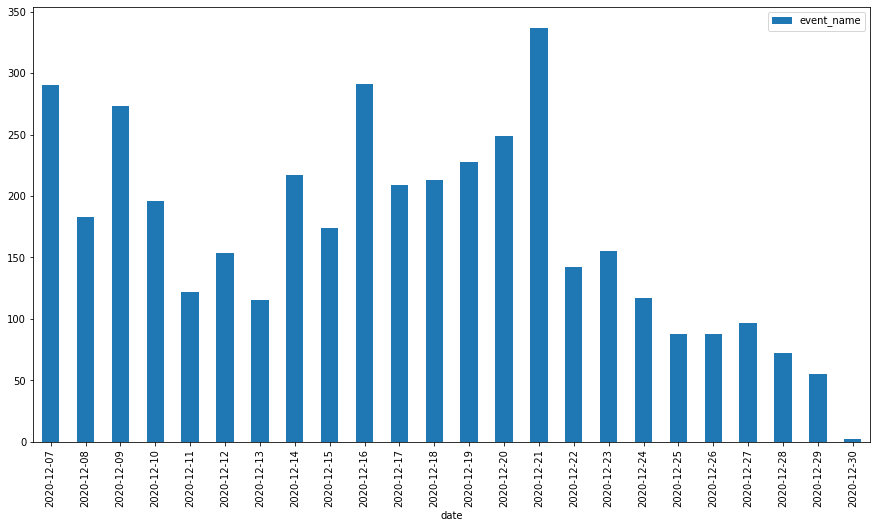

In [54]:
df_B.groupby('date').agg({'event_name': 'count'}).plot(kind='bar', figsize=(15, 8))
plt.show()

Для группы В: первую неделю неравномерно: то много событий, то мало, затем неделя равномерно и как в А 21.12 пик, после которого совсем небольшие количества событий.

## Оценка результатов A/B-тестирования

**Конверсия в покупки**

*Нулевая гипотеза*: Конверсия в группе A равна конверсии в группе B

*Альтернативная гипотеза*: Конверсия в группе A не равна конверсии в группе B

In [55]:
alpha=.05
successes = np.array([A_event_users.loc[2, 'nunique'], B_event_users.loc[2, 'nunique']])
trials = np.array([A_event_users.loc[0, 'nunique'], B_event_users.loc[0, 'nunique']])
p1 = successes[0]/trials[0] 
p2 = successes[1]/trials[1] 
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
difference = p1 - p2 

In [56]:
z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  0.10281767567786759
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Разница между конверсиями в группе А 31% и в группе В 28% не оказалась значимой. p-значение оказалось чуть больше 10%.

**Конверсия в просмотр карточек товаров**

*Нулевая гипотеза*: Конверсия в группе A равна конверсии в группе B

*Альтернативная гипотеза*: Конверсия в группе A не равна конверсии в группе B

In [57]:
alpha=.05
successes = np.array([A_event_users.loc[1, 'nunique'], B_event_users.loc[1, 'nunique']])
trials = np.array([A_event_users.loc[0, 'nunique'], B_event_users.loc[0, 'nunique']])
p1 = successes[0]/trials[0] 
p2 = successes[1]/trials[1] 
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
difference = p1 - p2 

In [58]:
z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  1.5371909704686715e-05
Отвергаем нулевую гипотезу: между долями есть значимая разница


Между долями есть значимая разница в группе А 65% и в группе В 56%, то есть это разница отрицательная и тоже не дает нам необходимых результатов.

**Конверсия в просмотр корзины**

*Нулевая гипотеза*: Конверсия в группе A равна конверсии в группе B

*Альтернативная гипотеза*: Конверсия в группе A не равна конверсии в группе B

In [59]:
alpha=.05
successes = np.array([A_event_users.loc[3, 'nunique'], B_event_users.loc[3, 'nunique']])
trials = np.array([A_event_users.loc[0, 'nunique'], B_event_users.loc[0, 'nunique']])
p1 = successes[0]/trials[0] 
p2 = successes[1]/trials[1] 
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
difference = p1 - p2 

In [60]:
z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  0.1766337419130104
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Разница между конверсиями в группе А 31% и в группе В 28% не оказалась значимой. p-значение оказалось чуть больше 17%.

## Общий вывод

1) даты маркетинговых мероприятий пересекаются с датами проведения теста,

2) пользователи теста recommender_system_test и теста interface_eu_test, пришлось их удалить, но после этого пользовталей стало 5099 из нужных по техзаданию 6000,

3) конверсия в группе А меньше конверсии группы В на 1-2%, а по техзаданию должно быть 10%,

4) количество пользователей из Европы всего 6,1%, а по техзаданию должно быть 15%

5) количество событий на пользователя в группе А больше группы В,

6) число событий по дням распределено неравномерно у А сначала небольшое количество, затем возрастает - достигает пика 21.12 и потом снижается, в группе В сразу большое количество затем уменьшается, потом опять возрастает и достигает пика также 21.12 и резко уменьшается,

7) в проверке гипотез в конверсии просмотра корзины и покупки не получилось отвергнуть нулевую гипотезу -> нет оснований считать конверсии в группах А и В разными, а в просмотр карточек товаров показало значимую разницу долей групп А и В, хотя это разница в пользу группы А.

**Из всего выше перечисленного можно сделать вывод, что А/В тест неудачен**